# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Our company wants to determine the "correct" salary for new job postings based on our existing job postings.  It is envisoned that this will take the guesswork out of the exisint process, and help to standardize salaries across departments.
In this effort, I will examine the job postings with salaries and then predict salaries for a new set of job postings.  As part of this effort, I will also determine which features in the data have the greatest impact on the salary of the position.

In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import xgboost as xgb
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

__author__ = "John Freeman"
__email__ = "dennis.freeman@southbridge.consulting"

In [2]:
def plot_feature(df, col, target, target_name, graph_num):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    plt.subplot(3, 5, graph_num)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)[target].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(3, 5, graph_num + 1)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)[target].mean()
        std = df.groupby(col)[target].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sn.boxplot(x = col, y = target, data=df)
    plt.xticks(rotation=45)
    plt.ylabel(target_name)
    
def encode_feature_df(df, cat_vars=None, num_vars=None):
    category_df = pd.get_dummies(df[cat_vars])
    numeric_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([category_df, numeric_df], axis=1)

def model_trainer(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = \
           cross_val_score(model, feature_df, target_df, cv=5, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])
    
def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')
    
def encode_label(df, col, target):
    categorical_dict ={}
    categories = df[col].cat.categories.tolist()
    for cat in categories:
        categorical_dict[cat] = train_df[train_df[col] == cat][target].mean()   
    df[col] = df[col].map(categorical_dict)

## Part 2 - DISCOVER

### Load the data into Pandas dataframes

In [3]:
train_features_df = pd.read_csv('data/train_features.csv')
train_salaries_df = pd.read_csv('data/train_salaries.csv')
test_features_df = pd.read_csv('data/test_features.csv')

### Clean the data
Visually check the data, look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
We see that there are column headers in the files, and that the file formats match between 
train and test features

In [4]:
train_features_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [5]:
train_salaries_df.head(10)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [6]:
test_features_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


Using info to check the data types of each column

In [7]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [8]:
train_salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [9]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


This shows that the datatypes are appropriate with object for strings and int for numeric features.
Also, the train and test data sets are matched by type.

Check if there are any duplicates in the supplied data sets.
This can lead to skewing the results during training

In [10]:
train_features_df.duplicated().sum()

0

In [11]:
train_salaries_df.duplicated().sum()

0

In [12]:
test_features_df.duplicated().sum()

0

Check if there are any missing values in the data set; if so, will show as true below

In [13]:
train_features_df.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [14]:
train_salaries_df.isnull().any()

jobId     False
salary    False
dtype: bool

In [15]:
test_features_df.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

Next, identify the category columns in the dataset, and create category and numeric column lists

In [16]:
train_features_df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [17]:
category_columns = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
numeric_columns = ['yearsExperience', 'milesFromMetropolis']

Check the non jobId and companyId category to see if values are there and resonable

In [18]:
for cat in category_columns[2:]:
    print(train_features_df[cat].value_counts())

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64
HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64
NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64
WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64


Next, check a summary of the numeric features

In [19]:
train_features_df.describe(include = [np.number])

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


The summary seems reasonable, as both the mean and standard deviation for the yearsExperience and 
milesFromMetropolis seem reasonable.
Next, use describe to include non-numeric features to further check for category count and uniqueness.

In [20]:
train_features_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362685243230,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In the next step, merge the train features and targets into single dataframe to help in organization later.  Also drop the original train dataframes to lessen memory requirements, etc.  Check that the merge completed successfully, and no rows were lost.

In [21]:
train_df = pd.merge(train_features_df, train_salaries_df, on='jobId')
del train_features_df
del train_salaries_df

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [23]:
train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


### Explore the data (EDA)

Next, use a boxplot and a distplot to check the distribution of the salary target.  This will also check if there are obvious patterns that should be examined. 

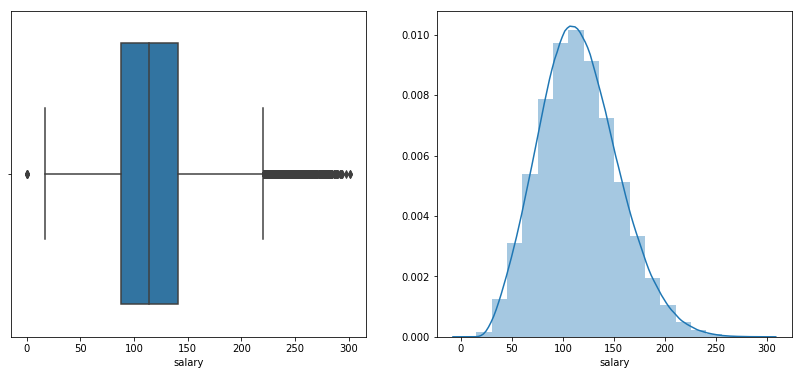

In [24]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sn.boxplot(train_df.salary)
plt.subplot(1,2,2)
sn.distplot(train_df.salary, bins=20)
plt.show()

As we can see in the boxplot, there are some outliers both above and below the "Maximum" and "Minimum" respectively.  I will investigate this further.
In the distplot, it shows a very nice distribution of the salary around a bell-shaped curve.
Below, I use the IQR - Interquartile Range rule to identify potential outliers, using the definition of Minimum and Maximum to calculate these values.  IQR is a somewhat arbitrary value, but has some value in spotting outliers.

In [25]:
stat = train_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper,lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


First, use the Minimum above to check salaries below this mark.

In [26]:
#Examine potential outliers - check below lower bounds
train_df[train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


Since the jobType shown is not a non-paid position, then it can be assumed that this is
corrupted or missing data, so these rows are dropped below

In [27]:
train_df = train_df[train_df.salary >= 8.5]

Next, I check the values above the Maximum.

In [28]:
train_df.loc[train_df.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [29]:
train_df[(train_df.salary > 220.5) & (train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


Since most of the jobTypes shown above are Executive level, which can be very well paid
due to the value they bring to the company, and the Junior level are in well-paying industries, Oil and Finance, and these are mostly advanced degrees, I determined that these are legitimate entries, so they will not be removed.
Next, for each feature, I give a Count plot on the left, and a plot against salary on the right.  This enables us to see the "sanity" of the data.  That is, does the data match the common sense test.  For example, we see that the salaries increase as the position becomes more managerial/executive/senior technical.  Also, the salaries are increased for higher level degrees.  The same is true for yearsExperience, as the salaries increase with more experience.  One thing noted is that the milesFromMetropolis is inversely related to salaries, i.e. the further from the Metropolis, the less the salaries.  This too is to be expected, as the cost of living is higher closer to the Metropolis.

<function matplotlib.pyplot.show(*args, **kw)>

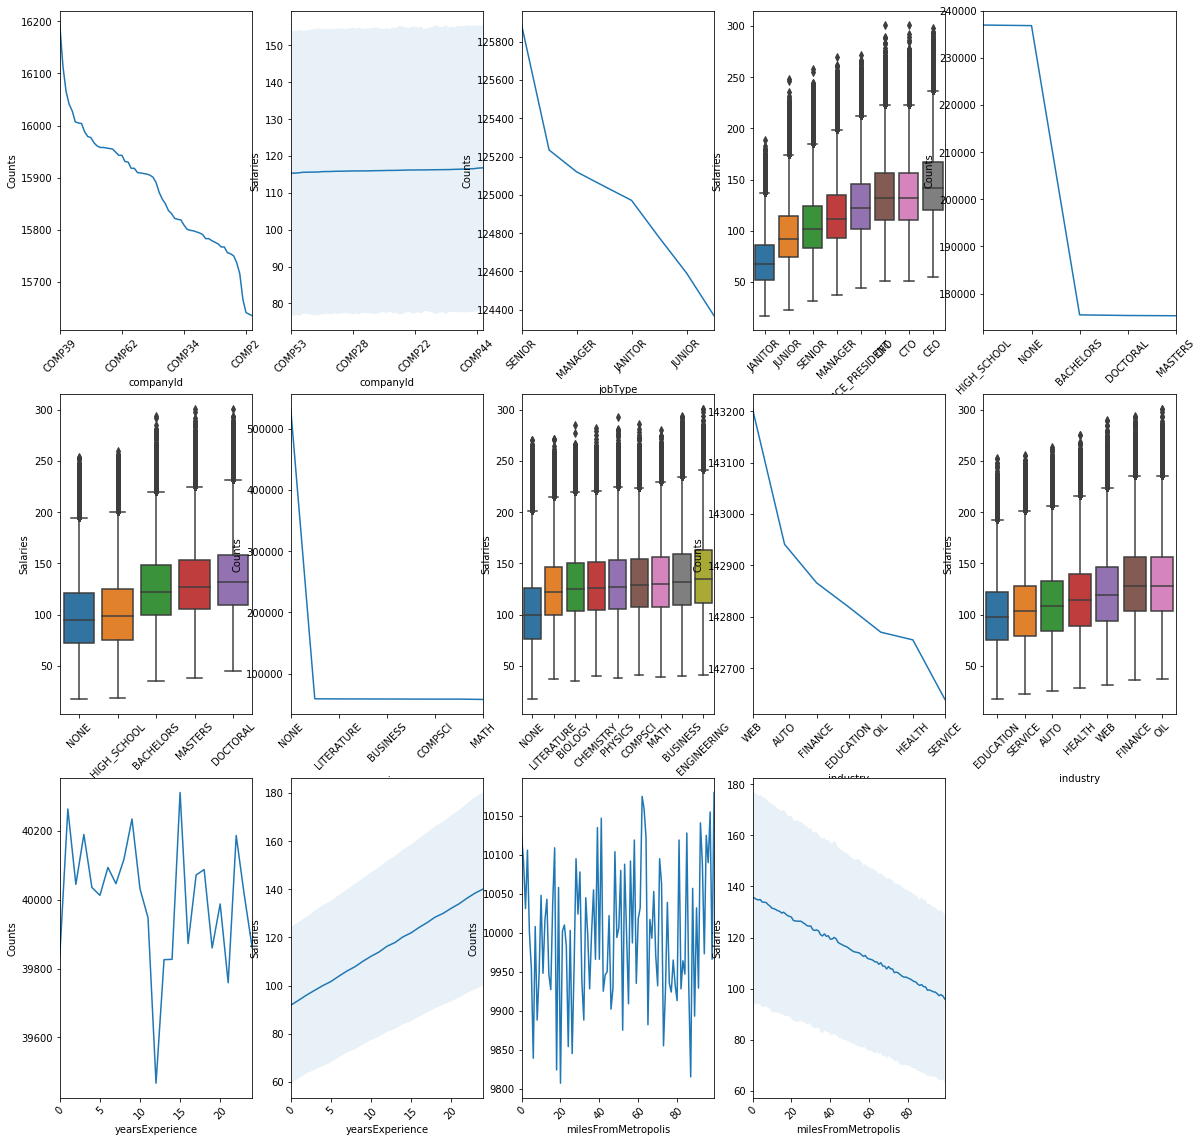

In [30]:
plt.subplots(figsize=(20, 20))
i = 1
for cat in category_columns[1:]:
    plot_feature(train_df, cat,'salary',"Salaries",i)
    i += 2
for cat in numeric_columns:
    plot_feature(train_df, cat,'salary',"Salaries",i)
    i += 2    
plt.show

#### The graphs above show the following correlation between the listed feature and the target (salary):
Company - Shows a weak association with Salary; Salaries don't seem to vary much between companies

JobType - Salary is clearly positively associated; more senior and executive posititions are higher paid

Degree - Salary is associated with degrees; higher degrees are paid more

Major - Business, Engineering and Math degree holders receive higher salaries

Industry - Oil and Finance industries are higher paid.

Years of Experience - There is a clear correlation with higher salaries given based on years of experience.

Miles from Metropolis - Generally, salaries decrease as the miles from Metropolis increases.

Next, we perform an encoding that better enables heat map diagramming by using the mean salary for each category.
Since the operation changes the dtype of the columns, I use a copy of the train_df for this operation.

In [31]:
# def encode_label(df, col, target):
#     cat_dict = {}
#     cats = df[col].cat.categories.tolist()
#     for cat in cats:
#         cat_dict[cat] = train_df[train_df[col] == cat][target].mean()   
#     df[col] = df[col].map(cat_dict)

In [32]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [33]:
train_df_copy = train_df.copy()
for col in train_df_copy.columns:
    if train_df_copy[col].dtype.name == "category":
        encode_label(train_df_copy,col,'salary')   

In [34]:
train_df_copy.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,115.345049,135.458547,130.505647,133.322042,115.735540,10,83,130
1,JOB1362684407688,115.756548,145.311425,101.921085,102.583864,121.645362,3,73,101
2,JOB1362684407689,116.224249,125.368630,135.490979,130.372436,115.735540,10,38,137
3,JOB1362684407690,116.199380,115.368518,135.490979,129.072085,109.435222,8,17,142
4,JOB1362684407691,115.888501,125.368630,125.454663,130.372436,130.747659,8,16,163


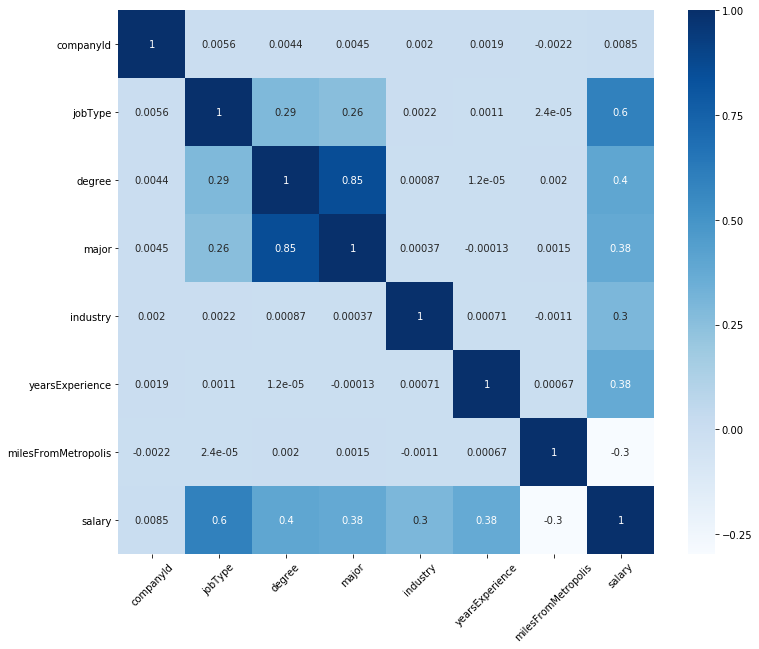

In [35]:
fig = plt.figure(figsize=(12, 10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sn.heatmap(train_df_copy[features + ['salary']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()

From this heatmap, there is shown a greater degree of correlation of jobType to salary, followed by degree, major, and yearsExperience.

There is a strong correlation between the features degree and major.  Using this analysis, enables me to determine if there is collinearity, and so dimension reduction is needed.  

Also, there is some correlation with industy to salary, and a negative correlation betwen milesfromMetropolis to salary.  This is because salaries are less in rural and suburban areas than metropolitan areas.

Overall, this shows that this is a clean dataset that can be modeled as is.

### Establish a baseline

Next, I create a reasonable metric (MSE in this case), and use an extremely simple model and measure its efficacy.
In this case I measure the average salary against the prediction for each each non-numeric category, as shown below.
This will be baseline for the model.

In [36]:
print("MSE for simple model for each category")
for col in category_columns[1:]:
    print(col + " - " + str(round(mean_squared_error(train_df_copy[col], train_df.salary),2)))

MSE for simple model for each category
companyId - 1498.91
jobType - 963.93
degree - 1257.61
major - 1284.07
industry - 1367.12


### Hypothesize solution

I will test 5 different models that I think will improve the results over the baseline model shown above.  Based
on the EDA, I will use:
Linear Regression - the boxplot and distplot show that there is a good degree of correlation between many of the features and the target (salary).  
make_pipline - this will use Standard Scalar, and PCA to transform the data before feeding it to the Linear Regression.
RandomForestRegressor - Because the features are broken into categories, a decision tree method is very likely to give good results.  The Random Forest Regressor prevents overfitting by decision trees by random sampling of data points, and random subset of features considered when splitting nodes.
GradientBoostingRegressor - This method is an ensemble of weak prediction models, typically decision trees, to make a strong predictor in stages (boosting).  Each subsequent model will fit to the residual of the previous model, thus providing improvement with each stage.
XGBoost - decision-tree-based ensemble ML algorithm that uses a gradient boosting framework.  It is about factor of 10 faster than Gradient Boosting.  This is becoming the new best of breed for stuctured and semi-structured data.

## DEVELOP

Next, we will cycle through creating features, tuning models, and training/validing models until the efficacy goal is reached.

### Engineer features

Next, we will change the dtype of the features in the test dataset to category.

In [37]:
for icat in ['companyId', 'jobType', 'degree', 'major', 'industry']:
    test_features_df[icat] = test_features_df[icat].astype('category')

Next, we make sure that the dataset is ready for modeling.

We will create any new features that are needed to enhance the model.  We will also shuffle the train dataset 
and reindex it.  This improves the cross-validation accuracy.
We will use one-hot-encoding to encode the category features.  Since in our EDA, we have determined that the companyId does not correlate well to the salary, i.e. there is very small difference between salaries based on
company, we will remove company from the categories.

In [38]:
category_vars = ['jobType', 'degree', 'major', 'industry']
number_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'
train_df = shuffle(train_df).reset_index()
feature_df = encode_feature_df(train_df, cat_vars=category_vars, num_vars=number_vars)
test_df = encode_feature_df(test_features_df, cat_vars=category_vars, num_vars=number_vars)

Use info to see the new categories created by the one_hot_encoding.

In [39]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999995 entries, 0 to 999994
Data columns (total 31 columns):
jobType_JANITOR           999995 non-null uint8
jobType_JUNIOR            999995 non-null uint8
jobType_SENIOR            999995 non-null uint8
jobType_MANAGER           999995 non-null uint8
jobType_VICE_PRESIDENT    999995 non-null uint8
jobType_CFO               999995 non-null uint8
jobType_CTO               999995 non-null uint8
jobType_CEO               999995 non-null uint8
degree_NONE               999995 non-null uint8
degree_HIGH_SCHOOL        999995 non-null uint8
degree_BACHELORS          999995 non-null uint8
degree_MASTERS            999995 non-null uint8
degree_DOCTORAL           999995 non-null uint8
major_NONE                999995 non-null uint8
major_LITERATURE          999995 non-null uint8
major_BIOLOGY             999995 non-null uint8
major_CHEMISTRY           999995 non-null uint8
major_PHYSICS             999995 non-null uint8
major_COMPSCI            

Create the target (salary) dataframe for the test dataset.

In [40]:
target_df = train_df[target_var]

### Create models

In [41]:
models = []
mean_mse = {}
cv_std = {}
res = {}
#define number of processes to run in parallel
num_procs = 4

#shared model paramaters
verbose_lvl = 0

#create models -- hyperparameter tuning already done by hand for each model
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
param_grid = [
    {'n_estimators': [50, 100, 150], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [50, 100], 'max_features': [2, 3, 4]}
]
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                           max_features=6, verbose=verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=150, max_depth=8, loss='ls', verbose=verbose_lvl,
                               min_samples_split=500, min_samples_leaf=50, max_features=6,
                               subsample=0.8 )
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.08,
                max_depth = 7, alpha = 10, n_estimators = 100, gamma=0, subsample=0.075)
                      
models.extend([lr, lr_std_pca, rf, gbm, xg_reg])

### Test models

Next, we will do a 5-fold cross validation on parallel models using MSE as evaluation metric, and print summaries.

In [42]:
print("Beginning cross validation")
for model in models:
    model_trainer(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.075, verbosity=1)
Average MSE:
 359.1851936466941
Standard deviation during CV:
 1.3088836273499107


### DEPLOY¶

### Select best model

From the models above, we select the best model, i.e. the model with the lowest MSE for use as our
Production model.

In [ ]:
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

### Automate pipeline
Now, use the best model from the results above for the Production run.

In [ ]:
#train model on entire dataset
model.fit(feature_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)

Below are the first 10 predictions from the best model.  We will check to make sure these look correct.

In [ ]:
for i in range(0,10):
    print(str(round(predictions[i],2)).rjust(8,' '))

### Deploy solution
Next, if the model is non-linear, we can query the model to show the importance of the feature in the
model.  These will also include the categories made by the one hot encoding of the feature.
We save the results to os files for later distribution and use.

In [ ]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#save results
save_results(model, mean_mse[model], predictions, feature_importances)

Below, we show a visualization of the feature importances
This will be extremely useful to business stakeholders

In [ ]:
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

In [ ]:
!cat model.txt

In [ ]:
!head feature_importances.csv

In [ ]:
!head predictions.csv